In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
def plot_eigvals_em_iters(ax, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None):
    eigs = jnp.array([jnp.linalg.eigh(gamma_init[j_ind_full,:,:])[0]] + [jnp.linalg.eigh(gamma_r[j_ind,:,:])[0]  for gamma_r in gamma_iter_list])
    color = plt.cm.rainbow(jnp.linspace(0, 1, len(eigs)))
    for i, e in enumerate(eigs):
        ax.plot(e[::-1], color=color[i], linewidth=1)

def get_eigval(mat, rank):
    eigvals = jnp.linalg.eigh(mat)[0]
    return eigvals[-rank]

def get_eigvec(mat, rank):
    eigvecs = jnp.linalg.eigh(mat)[1]
    return eigvecs[:,-rank]

def plot_cross_spec_eigval_em_iters(ax, eigrank, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None, 
        color='tab:blue', style='-', width=2):
    eigs = jnp.array([get_eigval(gamma_init[j_ind_full,:,:], eigrank)] + [get_eigval(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    ax.plot(eigs, color=color, linewidth=width, linestyle=style)

def get_eigvec_em_iters(eigrank, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None):
    eigvecs = jnp.array([get_eigvec(gamma_init[j_ind_full,:,:], eigrank)] + [get_eigvec(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    return eigvecs

def plot_eigvec_func_em_iters(ax, func, eigrank, dim, gamma_iter_list, gamma_init, j_ind=9, nz=None, color='tab:blue'):
    eigvecs = get_eigvec_em_iters(eigrank, gamma_iter_list, gamma_init, j_ind, nz=nz)
    res = func(eigvecs[:,dim])
    ax.plot(res, color=color, linewidth=2)

In [4]:
def plot_cross_spec_em_iters(ax, i, j, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind_full,i,j].real] + [gamma_r[j_ind,i,j].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind_full,i,j].imag] + [gamma_r[j_ind,i,j].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

def plot_cross_spec_func_em_iters(ax, func, i, j, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None, color='tab:blue', style='-', width=2):
    cs_real = jnp.array([func(gamma_init[j_ind_full,i,j])] + [func(gamma_r[j_ind,i,j]) for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color=color, linewidth=width, linestyle=style)

In [5]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0
def cif_alpha_log(alphas, xs):
    return jnp.exp(alphas[None,:,None] + xs)

In [6]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [7]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [8]:
num_iters = 50
lcfg_attrs = {}

init_use = 'flat-init'

if init_use == 'flat-init':

    init = 'flat-init'
    scale_init = 10000000 
    mcfg_attrs = {'emiters': num_iters,
                'init': init,
                'scale_init': scale_init}


if init_use == 'empirical-init':
    init = 'empirical-init'
    mcfg_attrs = {'emiters': num_iters,
                'init': init}


ocfg_attrs = {'obs_type': 'pp_relu'}

res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/batch/outputs/2024-11-22-temp']
# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-20',
#             '/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-21']

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
# alphas = sorted([r['cfg'].obs.alpha for r in res_load])
# Ls = sorted([r['cfg'].latent.L for r in res_load])


33 paths found meeting critera


In [9]:
K = 25
gamma_name = f'k{K}-chlg3-rank1-nz9'

L = 10
alpha = 10
lsel = {'L': L,
        'gamma': gamma_name}
msel = {}
osel = {'alpha': alpha}
res = filter_loaded(res_load, lsel, msel, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']
nz_model = res['params']['model_nonzero_inds']
nz_true = res['params']['true_nonzero_inds']
K = gamma_true.shape[-1]
Nnz = nz_model.size

Returned single result.


In [10]:
Ls = jnp.array([10, 25, 50])
alphas = jnp.array([10, 25, 50])
Ks = jnp.array([3, 10, 25])

In [11]:
from cohlib.jax.dists import naive_estimator, sample_ccn_rank1
from cohlib.jax.simtools import load_gamma


naive_ests = jnp.zeros((Ls.size, alphas.size, Nnz, K, K), dtype=complex)
oracle_ests = jnp.zeros((Ls.size, alphas.size, Nnz, K, K), dtype=complex)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        print(f'L: {L}, alpha: {alpha}' )
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)

        
        cfg = res['cfg']
        lcfg = cfg.latent
        ocfg = cfg.obs
        gamma_true = res['gamma_true_full']
        K = gamma_true.shape[-1]

        gamma_load = load_gamma(cfg)
        nz_target = gamma_load['target_inds']
        eigvec = gamma_load['eigvec']
        eigval = gamma_load['eigval']

        lrk = jr.key(lcfg.seed)

        zs_target = sample_ccn_rank1(lrk, eigvec, eigval, K, lcfg.L)
        gamma_full_dummytarget = gamma_true.copy()
        gamma_full_dummytarget = gamma_full_dummytarget.at[nz_target,:,:].set(jnp.eye(K, dtype=complex))

        zs = sample_from_gamma(lrk, gamma_full_dummytarget, lcfg.L)
        zs = zs.at[nz_target,:,:].set(zs_target)

        zs_0dc = jnp.apply_along_axis(add0, 0, zs)
        xs = jnp.fft.irfft(zs_0dc, axis=0)
        params = jnp.array([ocfg.alpha for _ in range(K)])


        obs, obs_params = sample_obs(xs, params)
        naive_est = naive_estimator(obs, nz_model)
        naive_ests = naive_ests.at[l,a,:,:,:].set(naive_est * 1e6)

        gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz_model,:,:], zs[nz_model,:,:].conj()).mean(-1)
        oracle_ests = oracle_ests.at[l,a,:,:,:].set(gamma_oracle)

L: 10, alpha: 10
Returned single result.
L: 10, alpha: 25
Returned single result.
L: 10, alpha: 50
Returned single result.
L: 25, alpha: 10
Returned single result.
L: 25, alpha: 25
Returned single result.
L: 25, alpha: 50
Returned single result.
L: 50, alpha: 10
Returned single result.
L: 50, alpha: 25
Returned single result.
L: 50, alpha: 50
Returned single result.


In [12]:
naive_color = 'tab:red'
naive_style = 'dashed'
naive_width = 2

true_color = 'k'
true_style = 'solid'
true_width = 2

oracle_color = 'tab:green'
oracle_style = 'dotted'
oracle_width = 2.5

est_color = 'tab:blue'
est_style = 'solid'
est_width = 2

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


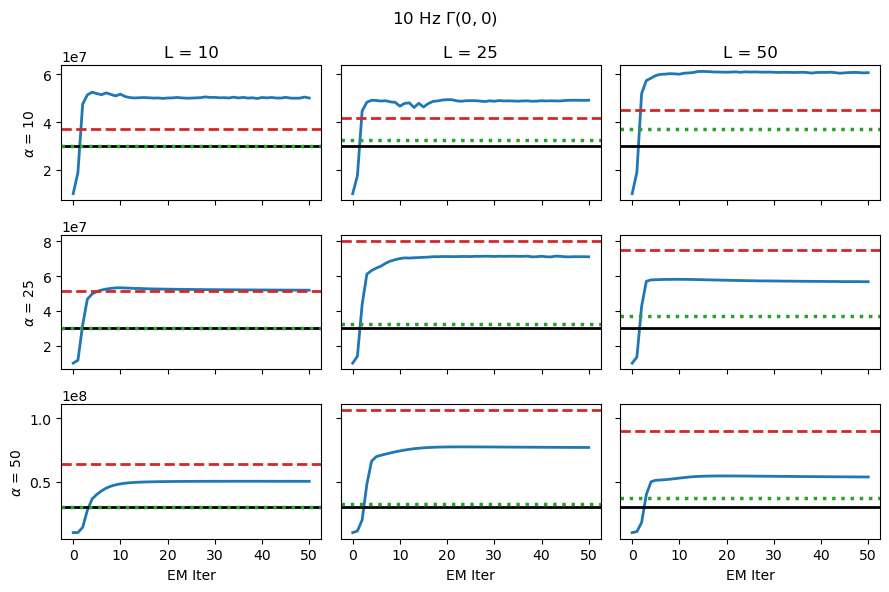

In [13]:
ov1 = 1
jind = 0
jind_full = 9

K_plot = [0]
# def func(x):
#     return 10*jnp.log10(jnp.real(x))
func = jnp.real
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey='row')
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        for k in K_plot:
            plot_cross_spec_func_em_iters(ax[a,l], func, k,k, res['track']['gamma'], res['gamma_init'], 
                j_ind = jind, color=est_color, style=est_style, width=est_width)
            ax[a,l].axhline(func(res['gamma_true_full'][jind_full,k,k]), 
                linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_ests[l,a,jind,k,k]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_ests[l,a,jind,k,k]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        if l == 0:
            ax[a,l].set_ylabel(r'$\alpha$' f' = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')
fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\Gamma({K_plot[0]}, {K_plot[0]})$')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


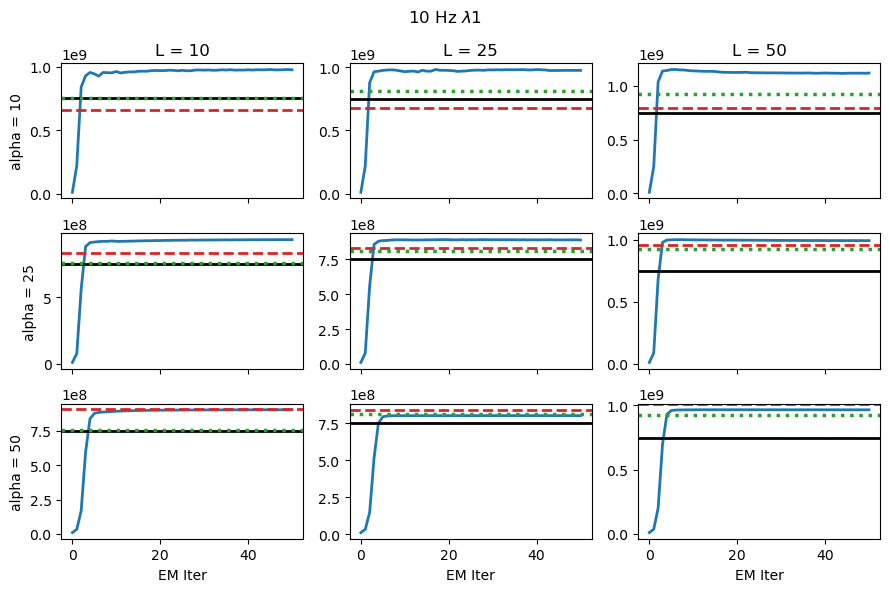

In [14]:
eigrank = 1
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey=False)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        true_eigval = get_eigval(gamma_true[jind_full,:,:], eigrank)

        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        oracle_eigval = get_eigval(gamma_oracle[jind,:,:], eigrank)
        naive_eigval = get_eigval(gamma_naive[jind,:,:], eigrank)

        plot_cross_spec_eigval_em_iters(ax[a,l], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[a,l].axhline(true_eigval, 
            linestyle=true_style, color=true_color, linewidth=true_width)
        ax[a,l].axhline(oracle_eigval, linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        ax[a,l].axhline(naive_eigval, linestyle=naive_style, color=naive_color, linewidth=naive_width)

        # ax[a,l].axhline(true_eigval, color='k', label='True')
        # ax[a,l].axhline(naive_eigval, linestyle='--', color=naive_color, label='Naive')
        # ax[a,l].axhline(oracle_eigval, linestyle='--', color='tab:green', label='Oracle',linewidth=3)

        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda {eigrank}$')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


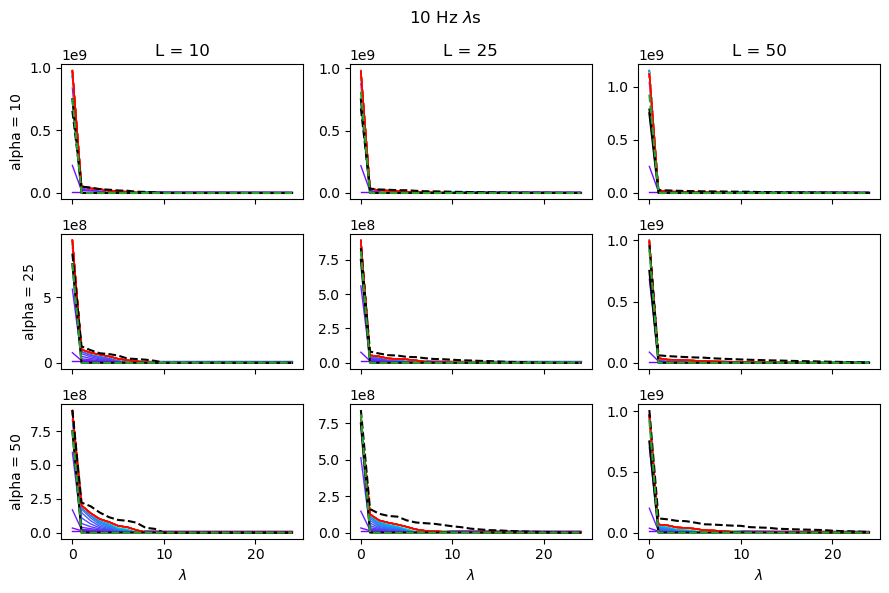

In [15]:
eigrank = 1
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey=False)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']

        gamma_true = res['gamma_true_full']
        gamma_oracle = oracle_ests[l,a,:,:,:]
        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_est = res['gamma']

        evs_true, _ = jnp.linalg.eigh(gamma_true[jind_full,:,:])
        evs_oracle, _ = jnp.linalg.eigh(gamma_oracle[jind_full,:,:])
        evs_naive, _ = jnp.linalg.eigh(gamma_naive[jind_full,:,:])
        evs_est, _ = jnp.linalg.eigh(gamma_est[jind_full,:,:])

        # plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)
        plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[a,l].plot(evs_true[::-1], color='k')
        ax[a,l].plot(evs_naive[::-1], linestyle='--', color='k')
        ax[a,l].plot(evs_oracle[::-1], linestyle='--', color='tab:green')

        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel(r'$\lambda$')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda$s')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


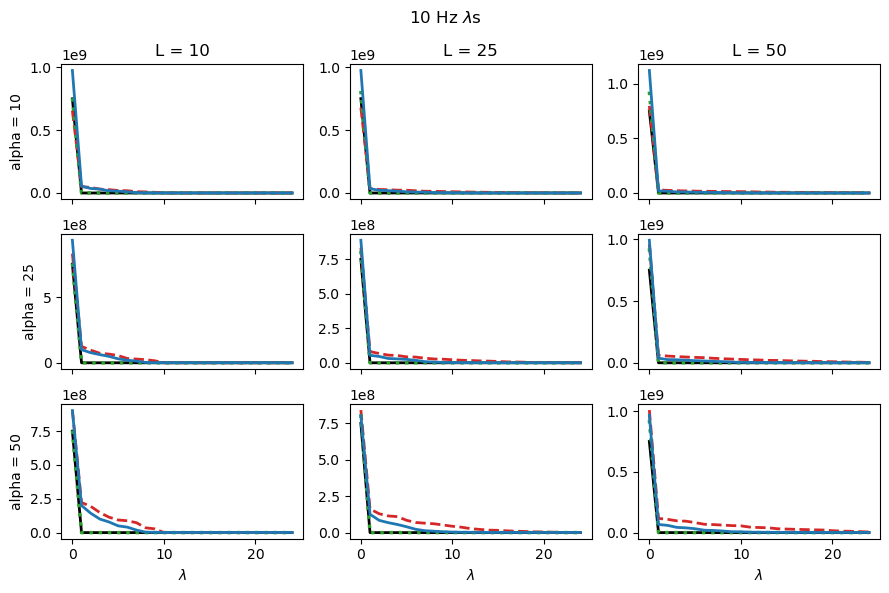

In [16]:
eigrank = 1
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey=False)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']

        gamma_true = res['gamma_true_full']
        gamma_oracle = oracle_ests[l,a,:,:,:]
        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_est = res['gamma']

        evs_true, _ = jnp.linalg.eigh(gamma_true[jind_full,:,:])
        evs_oracle, _ = jnp.linalg.eigh(gamma_oracle[jind_full,:,:])
        evs_naive, _ = jnp.linalg.eigh(gamma_naive[jind_full,:,:])
        evs_est, _ = jnp.linalg.eigh(gamma_est[jind_full,:,:])

        # plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)
        # plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)

        ax[a,l].plot(evs_true[::-1], linestyle=true_style, color=true_color, linewidth=true_width)
        ax[a,l].plot(evs_naive[::-1],  linestyle=naive_style, color=naive_color, linewidth=naive_width)
        ax[a,l].plot(evs_oracle[::-1],  linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        ax[a,l].plot(evs_est[::-1],  linestyle=est_style, color=est_color, linewidth=est_width)

        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel(r'$\lambda$')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda$s')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


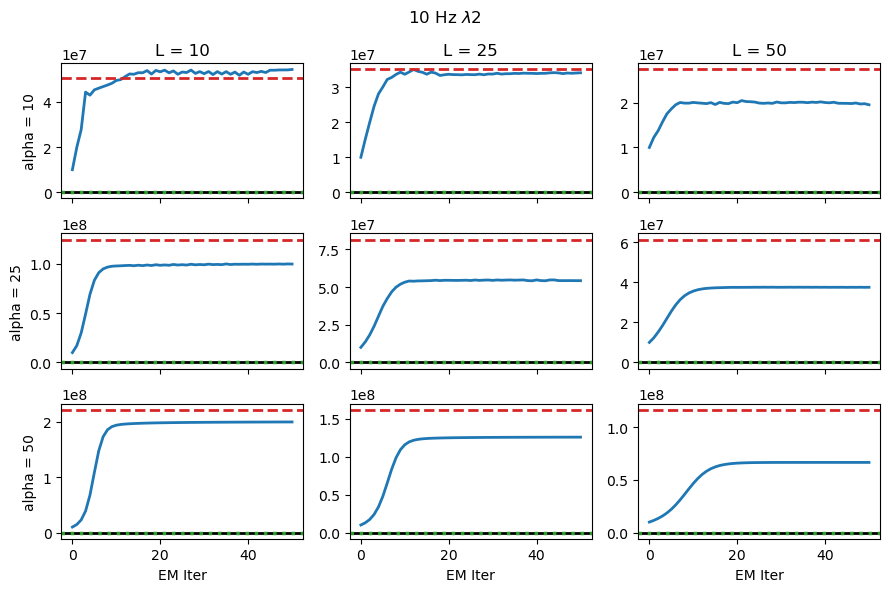

In [17]:
eigrank = 2
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey=False)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        true_eigval = get_eigval(gamma_true[jind_full,:,:], eigrank)

        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        oracle_eigval = get_eigval(gamma_oracle[jind,:,:], eigrank)
        naive_eigval = get_eigval(gamma_naive[jind,:,:], eigrank)

        plot_cross_spec_eigval_em_iters(ax[a,l], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[a,l].axhline(true_eigval, linestyle=true_style, color=true_color, linewidth=true_width)
        ax[a,l].axhline(naive_eigval, linestyle=naive_style, color=naive_color, linewidth=naive_width)
        ax[a,l].axhline(oracle_eigval, linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)

        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda {eigrank}$')
plt.tight_layout()

# Interest - so need to rotate?

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


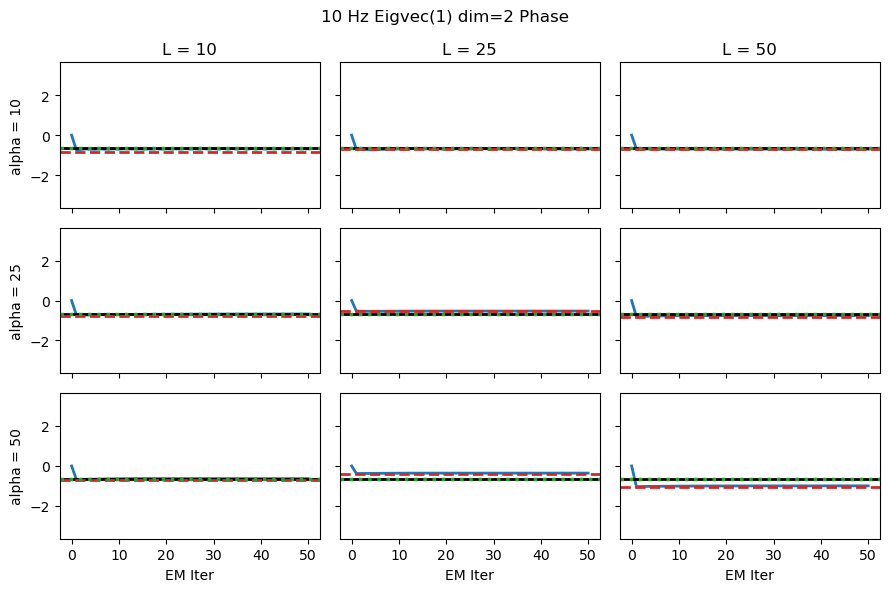

In [18]:
eigrank = 1
func = jnp.angle
z = 0
dims = jnp.array([0,1,2]) + 3*z
# dims = jnp.arange(1)
dims = [1]
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        

        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']


        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        true_eigvec = get_eigvec(gamma_true[jind_full,:,:], eigrank)
        oracle_eigvec = get_eigvec(gamma_oracle[jind,:,:], eigrank)
        naive_eigvec = get_eigvec(gamma_naive[jind,:,:], eigrank)

        for dim in dims:
            plot_eigvec_func_em_iters(ax[a,l], func, eigrank, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
            ax[a,l].axhline(func(true_eigvec[dim]), linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_eigvec[dim]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_eigvec[dim]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)


        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')
        ax[a,l].set_ylim([-jnp.pi - 0.5, jnp.pi + 0.5])

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'Eigvec({eigrank}) dim={dim+1} Phase')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


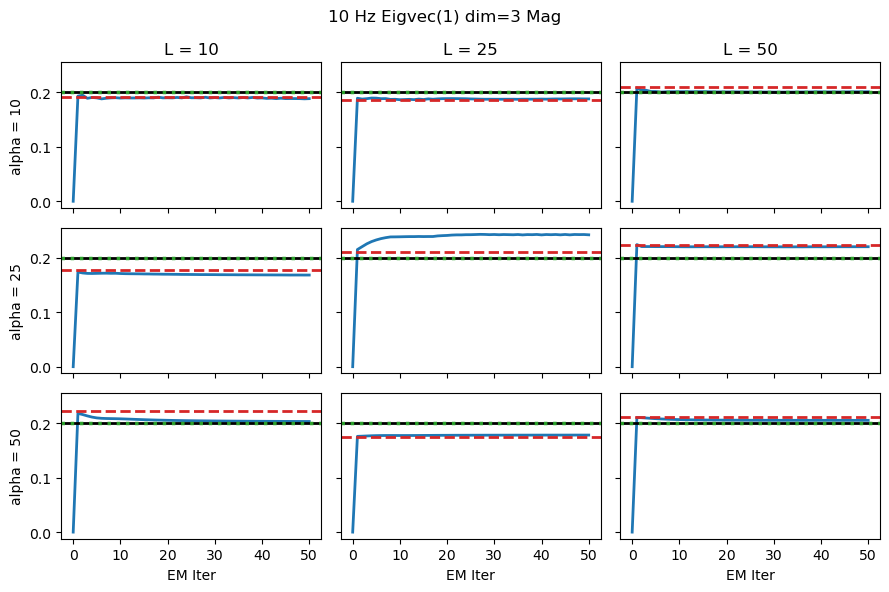

In [19]:
eigrank = 1
func = jnp.abs
z = 0
dims = jnp.array([0,1,2]) + 3*z
# dims = jnp.arange(1)
dims = [2]
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(9,6), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        

        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']


        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        true_eigvec = get_eigvec(gamma_true[jind_full,:,:], eigrank)
        oracle_eigvec = get_eigvec(gamma_oracle[jind,:,:], eigrank)
        naive_eigvec = get_eigvec(gamma_naive[jind,:,:], eigrank)

        for dim in dims:
            plot_eigvec_func_em_iters(ax[a,l], func, eigrank, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
            ax[a,l].axhline(func(true_eigvec[dim]), linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_eigvec[dim]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_eigvec[dim]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
            


        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'Eigvec({eigrank}) dim={dim+1} Mag')
plt.tight_layout()